In [ ]:
import sys
import logging


base_path = '/notebooks/eipi10/python-book/arsenal'
sys.path.append(base_path)
current_path = '.'
current_data_path = current_path + "/data"


logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import time


from pprint import pprint
from eipi10.ml2.utils import *

pd.set_option('display.width', 1000)
os.environ["https_proxy"] = "http://web-proxy.rose.hp.com:8080"
os.environ["http_proxy"] = "http://web-proxy.rose.hp.com:8080"

%matplotlib inline

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

#当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload 



### 1.44 数据库使用心得   【2019-03-22】

虽然不同数据库的特点不同，但基本的准则确几乎相同。

- 对于并发高的query，一定要速度快，最好能在秒级（少于三秒）返回结果，否则性能会受影响。
- 对于慢的query，尽量放在后台来运行，避免前端长时间等待。
- 数据库日常时段，避免后台有大量慢的query，cpu的占用率要控制。
- 数据库空闲时段，可以预先计算生成一些数据。在日常时段，这些数据可以被用户快速查询，避免在线计算。
- 对于返回记录多的查询（超过10000条以上），可以把数据生成到磁盘文件，然后前端来调用文件，这样或许性能更好。

对于像Redshift这样MPP的数据库，形如select * from a where id=?的查询，不管表的大小，其性能一般，而对于MySQL, PostgreSQL这样的数据库，如果id上有索引，性能会非常好。在前端的应用中，大部分的查询都是基于主键来查询的，则决定了MySQL, PostgreSQL适合这样的场景，而Redshift不适合。

而在数据处理和分析中，查询往往是多表连接，而且有多种查询条件（很难命中索引），往往还有groupby，甚至窗口函数，这样的情况，Redshift性能很好，而MySQL, PostgreSQL性能很一般。这决定了，在数据处理和分析中，Redshift更加适合，MySQL, PostgreSQL不适合。

### 1.43 s3目录转换   【2019-03-21】

把s3目录的进行改变。下面的实例中，把web/\[openid\]变成openid/right(\[openid\],1)/\[openid\]。


**获取当前s3列表**
```shell
aws s3 ls s3://hpi-cn-local-business-css-wechat/css-wechat-analysis/prod/user-profile/data/web/  > file_list.txt

```

**获取文件名**
```shell
echo > openid.txt
i=0
while read line
do 
  if [ ${line: -1} = "/" ]; then
    echo -----------------------------------------
    folder=`echo $line | awk '{print $2}'`
    echo ${folder: 0:-1} in ${line}  
    echo ${folder: 0:-1} >> openid.txt
  fi
  let i=$i+1
done < ls_openid.txt

```

**格式转换**
```shell
i=0
j=0
source=s3://hpi-cn-local-business-css-wechat/css-wechat-analysis/prod/user-profile/data/web
target=s3://hpi-cn-local-business-css-wechat/css-wechat-analysis/prod/user-profile/data/openid
cnt=`wc -l openid.txt | awk '{print $1}'`
while read line
do 
  let i=$i+1
  echo -------------------$i/$cnt----------------------
  
  # 转换和控制逻辑。比如下面的逻辑：目录如果是数字，则不用复制。
  if [ -n "`echo $line | sed 's/[0-9]//g'`" ] && [ '$line' != 'evaluate' ]; then   
    
    let j=$j+1
    # 用目录的最右边的字符，作为上层的目录名称 
    echo $j: aws s3 cp $source/$line/ $target/${line: -1}/$line/ --recursive 
    aws s3 cp $source/$line/ $target/${line: -1}/$line/ --recursive 
  else
    echo  ignore because $line is number
  fi    
done < openid.txt
```

### 1.42 EDA中的几个可视化方法   【2018-11-20】

EDA ：Exploratory Data Analysis

**计算一个列比另外一个列大的比例分布**  
这个来自competitive-data-science里面的第二周EDA的内容。主要是显示一下一个列比另外一个列大的情况，可以用于探索一个列是否比另外一个列大的情况。

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def autolabel(arrayA):
    ''' label each colored square with the corresponding data value. 
    If value > 20, the text is in black, else in white.
    '''
    arrayA = np.array(arrayA)
    for i in range(arrayA.shape[0]):
        for j in range(arrayA.shape[1]):
                plt.text(j,i, "%.2f"%arrayA[i,j], ha='center', va='bottom',color='w')

def hist_it(feat):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.8)
    feat[Y==1].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.5)
    plt.ylim((0,1))
    
# 计算一个列，比另外一个列大的比例分布    
def gt_matrix(feats, df, sz=16):
    a = []
    for i,c1 in enumerate(feats):
#         print('='*50)
        b = [] 
        for j,c2 in enumerate(feats):
#             print('-'*50)
            mask = (~df[c1].isnull()) & (~df[c2].isnull())
#             print(c1, c2)
#             print(mask)
            if i>=j:
                b.append((df.loc[mask,c1].values>=df.loc[mask,c2].values).mean())
            else:
                b.append((df.loc[mask,c1].values>df.loc[mask,c2].values).mean())

        a.append(b)

    plt.figure(figsize = (sz,sz))
    print(a)
    plt.imshow(a, interpolation = 'None')
    _ = plt.xticks(range(len(feats)),feats,rotation = 90)
    _ = plt.yticks(range(len(feats)),feats,rotation = 0)
    autolabel(a)

        one       two     three four  five
a       NaN -0.263206  0.380413  bar   0.0
b -0.731498 -0.419401 -1.286448  bar   0.0
c  0.895255  0.024684 -2.899255  NaN   1.0
e -0.977362  1.368067 -0.882339  bar   0.0
f       NaN       NaN -0.640988  bar   1.0
h -1.435870 -0.058584  0.389736  bar   NaN
['one', 'two', 'three', 'five']
[[1.0, 0.25, 0.5, 0.0], [0.75, 1.0, 0.6, 0.25], [0.5, 0.4, 1.0, 0.2], [1.0, 0.75, 0.8, 1.0]]


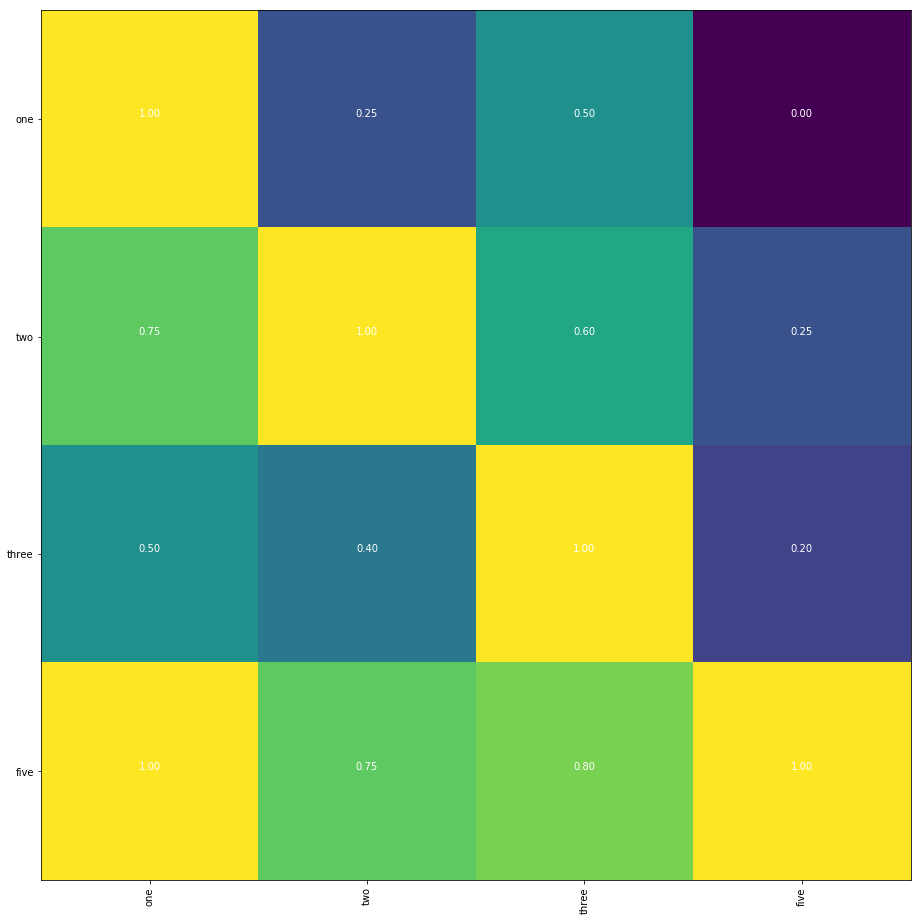

In [73]:
df = pd.DataFrame(np.random.randn(6, 3), index=['a', 'b', 'c', 'e', 'f', 'h'],
                  columns=['one', 'two', 'three'])

df['four'] = 'bar'
df['five'] = df['one'] > 0
df.loc['a', 'one'] = float('NaN')
df.loc['f', 'one'] = float('NaN')
df.loc['f', 'two'] = float('NaN')
df.loc['c', 'four'] = float('NaN')
df.loc['h', 'five'] = float('NaN')

# df.replace('NaN', -999, inplace=True)
print(df)

cat_cols = list(df.select_dtypes(include=['object']).columns)
num_cols = list(df.select_dtypes(exclude=['object']).columns)
print(num_cols)

# build 'mean(feat1 > feat2)' plot
gt_matrix(num_cols,df, 16)


In [76]:
from sklearn import datasets

iris = datasets.load_iris()
iris

{'DESCR': 'Iris Plants Database\n====================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)\n    ============== ==== ==== ======= ===== ==

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[1.0, 1.0, 1.0, 1.0], [0.0, 1.0, 0.3333333333333333, 1.0], [0.0, 0.6666666666666666, 1.0, 1.0], [0.0, 0.0, 0.0, 1.0]]


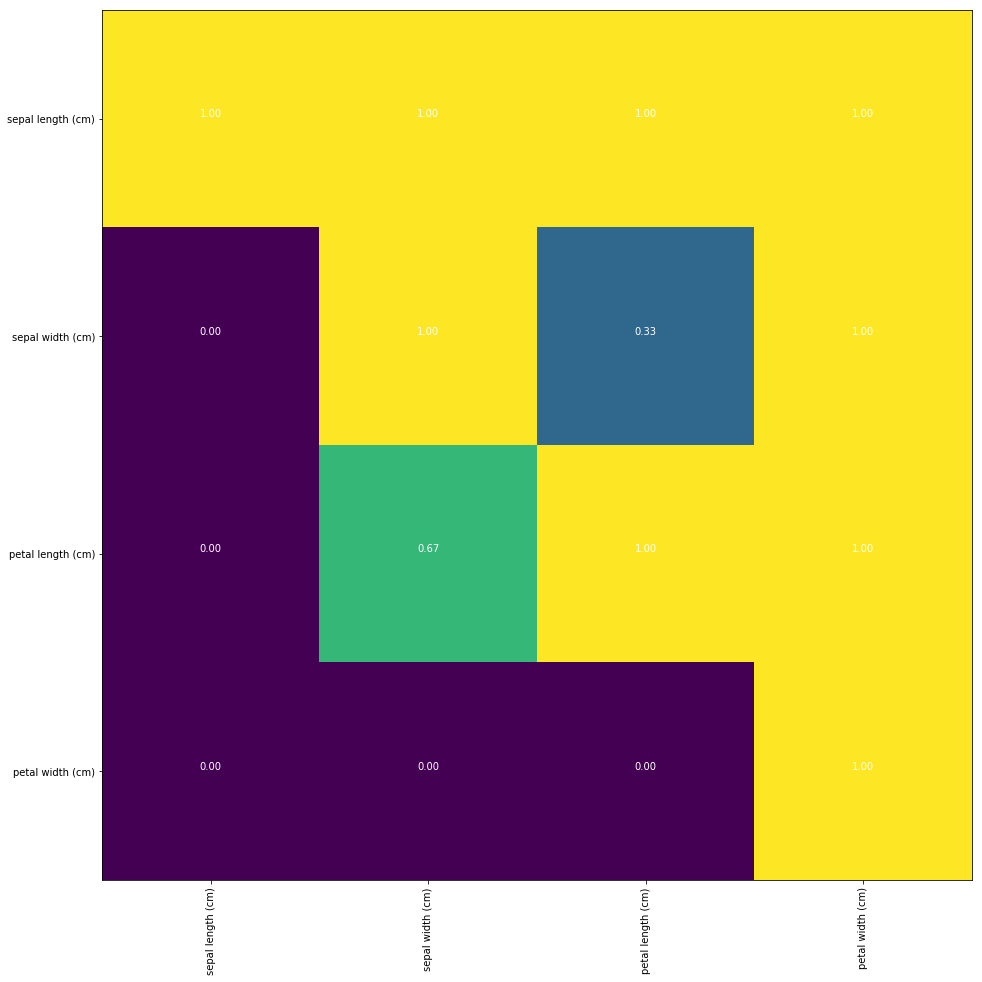

In [104]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
cat_cols = list(df.select_dtypes(include=['object']).columns)
num_cols = list(df.select_dtypes(exclude=['object']).columns)
print(num_cols)

# build 'mean(feat1 > feat2)' plot
gt_matrix(num_cols,df, 16)

**显示不同类别数据的直方图分布**

用于观察不同类的某个变量值的分布，非常不错的。

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


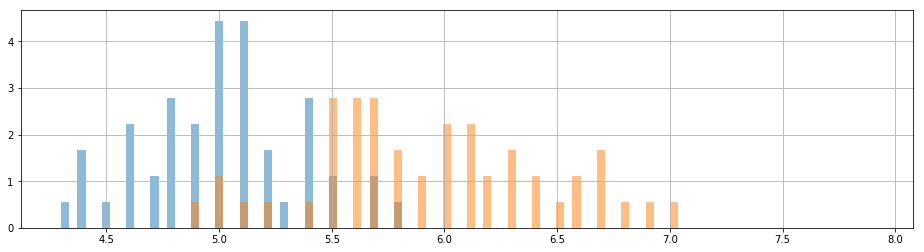

In [110]:
def hist_it1(feat, normed=True):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)  #看上去normed好像没啥用
    feat[Y==1].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)
#     plt.ylim((0,1))

Y = iris.target
print(df.head())

# 下图中棕色部分显示的公共部分
hist_it1(df['sepal length (cm)'])





/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74b3636860>,
      dtype=object)

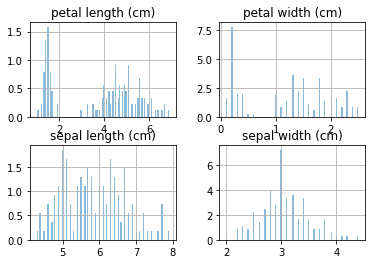

In [111]:
df.hist(bins=100,normed=True,alpha=0.5)

### 1.41  python的一些画图工具 【2018-11-15】

https://www.zhihu.com/question/39684179

Visualization tools
- [Seaborn](https://seaborn.pydata.org/) : 基于matplotlib的高级可视化效果库
- [Plotly](https://plot.ly/python/)：交互信息可视化的工具。实现了在线导入数据做可视化并保存内容在云端server的功能。
- [Bokeh](https://github.com/bokeh/bokeh)：可以是可以交互
- [ggplot](http://ggplot.yhathq.com/): 和R语言那个GGPLOT2比起来，简直是感觉在用两个包
- [Graph visualization with NetworkX](https://networkx.github.io/)：



In [11]:
~True & ~True

-2

In [13]:
~False & ~True

-2

In [12]:
~False & ~False

-1